<a href="https://colab.research.google.com/github/Light896cart/CV/blob/main/augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***В этом репозитории мы рассмотрим аугментацию данных 🌟, ее суть и применение в области компьютерного зрения 👁️‍🗨️. Мы обсудим основные методы аугментации, их влияние на качество моделей 📊 и предоставим практические примеры работы с аугментацией в задачах компьютерного зрения 🚀.***

In [107]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision

from PIL import Image
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt


import zipfile
import os

In [36]:
# Создаем кастомный датасет
class CustomData(Dataset):
    def __init__(self, path_csv, transform=None):
        self.path_csv = path_csv
        self.transform = transform
        self.df = pd.read_csv(path_csv)

    def __len__(self):
        return len(self.df['image'])

    def __getitem__(self, idx):
        img_name = str(self.df['image'][idx])
        label_str = self.df['label'][idx]

        # Преобразование строки метки в тензор
        label = torch.tensor(ast.literal_eval(label_str.replace(' ', ',')))

        # Загрузка изображения
        img_path = f'cars/Cars Dataset/{str(self.df["path"][idx])}/{img_name}'
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)
            if img.size(0) == 1:  # Если 1 канал
                img = img.repeat(3, 1, 1)  # Копируем по каналам

        return img, label

3352


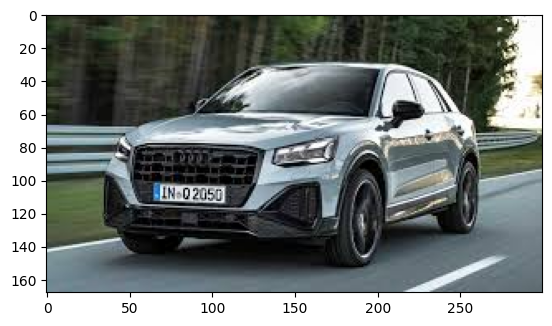

In [58]:
path_csv = '/content/cars/Cars Dataset/dataset.csv'
dataset = CustomData(path_csv)

# Отображаем изображение
def visual_img(daset):
  for image, _ in daset:
    try:
      plt.imshow(image)
    except TypeError:
      plt.imshow(image.permute(1,2,0))

    plt.show()
    break

# Выводим размер изначального датасета: 3352
print(len(dataset))
visual_img(dataset)

In [59]:
# Определим трансформации для аугментации данных
transform = transforms.Compose([
    transforms.RandomRotation(30),  # Случайный поворот на угол до 30 градусов
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Случайный сдвиг по оси X и Y
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize((0.5,), (0.5,))  # Нормализация значений пикселей
])

***Один из первых и простейших вариантов аугментации заключается в применении различных трансформаций к изображениям.***

***Например, мы можем добавить случайный угол поворота 🔄, изменить цвет, добавить цвет, изменить контрастность или просто выполнить сдвиг по осям X и Y. Таким образом, если у нас есть датасет из 1000 изображений, он останется на уровне 1000 изображений, но каждую эпоху мы будем случайным образом изменять эти изображения. Это означает, что каждое новое прохождение через датасет будет представлять собой уникальный набор изображений 🎨***

3352


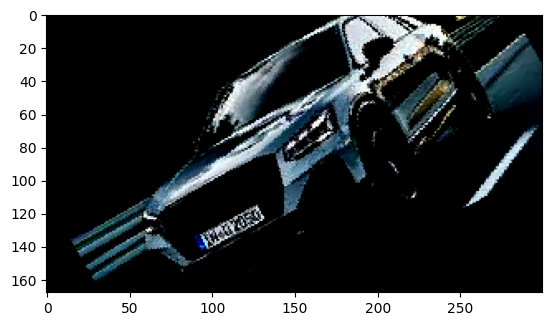

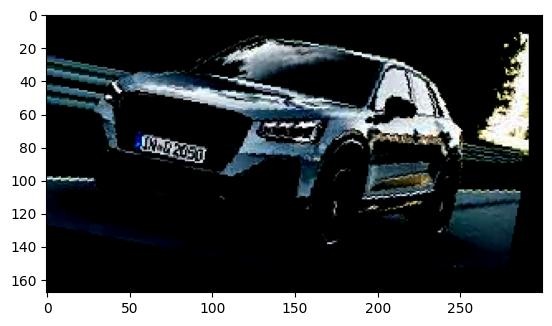

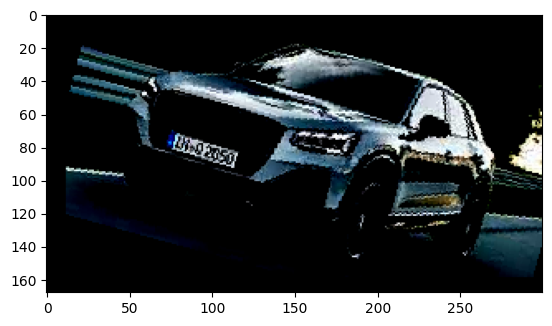

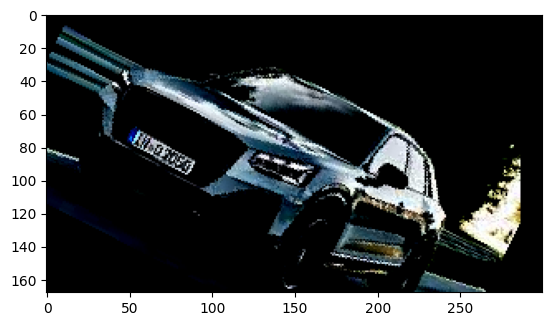

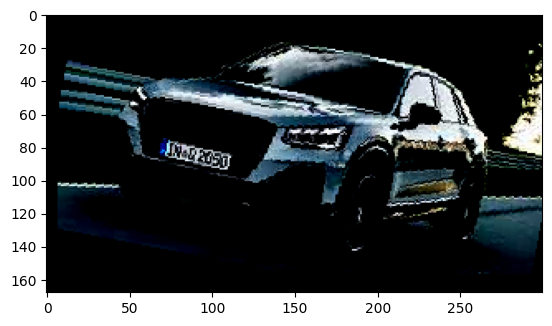

In [61]:
dataset_aug = CustomData(path_csv,transform)
print(len(dataset_aug))

# Отображаем наше изображение несколько раз, чтобы увидеть, как оно может изменяться используя трансформацию для аугментации.
for _ in range(5):
  visual_img(dataset_aug)

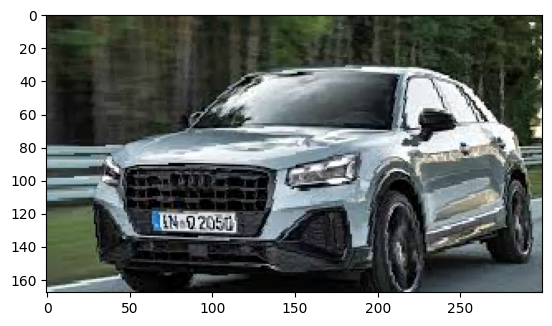

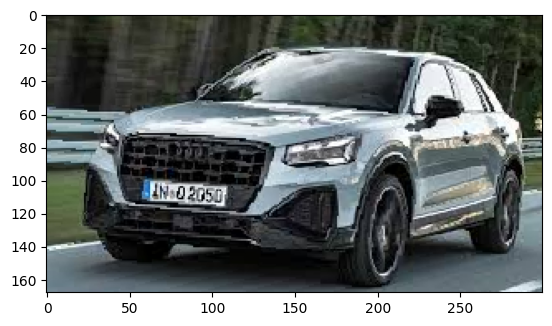

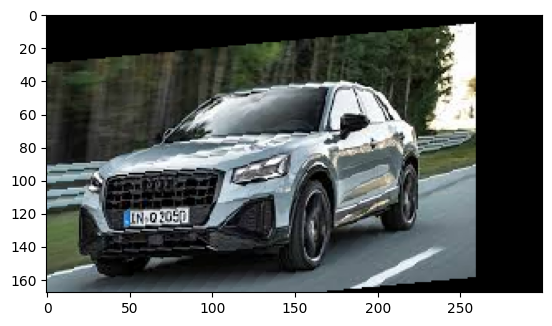

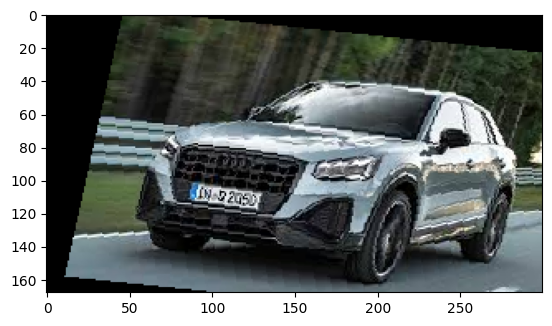

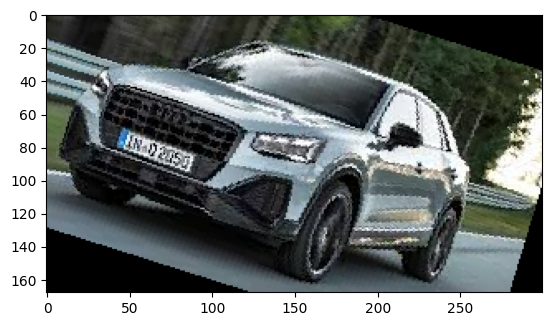

In [72]:
transform = transform = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor(),
    ])

# Применение афинных преобразований для аугментации
dataset_afin = CustomData(path_csv,transform)

for _ in range(5):
  visual_img(dataset_afin)

***Теперь поговорим о более трудной техники***
***Mixup — это техника аугментации данных, которая создает новые обучающие примеры путем линейного смешивания двух изображений и их соответствующих меток. Это может помочь улучшить обобщающую способность модели, особенно в задачах классификации.***

In [89]:
# Определим новый трансформ
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Изменение размера изображений до 512x512 пикселей
    transforms.ToTensor(),  # Преобразование изображения в тензор
])

In [90]:
dataset_mix = CustomData(path_csv,transform)
train_loader = DataLoader(dataset_mix, shuffle=True, batch_size=32)

In [91]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(3,12,3)       # Входные каналы: RGB (3), выходные каналы: (12), ядро (3x3)
        self.pool = nn.MaxPool2d(2,2)         # Пулинг с ядром (2x2) и шагом (2)
        self.conv2 = nn.Conv2d(12,24,3)      # Входные каналы: (12), выходные каналы: (24), ядро (3x3)
        self.relu = nn.ReLU()                 # Активация ReLU
        self.flat = nn.Flatten()              # Преобразование тензора в одномерный
        self.linear = nn.Linear(24 * 126 * 126 ,7) # Полносвязный слой на выходе

    def forward(self, x):
        x = self.relu(self.conv1(x))         # Применяем первый свёрточный слой и активацию
        x = self.pool(x)                      # Применяем первый пулинг
        x = self.relu(self.conv2(x))         # Применяем второй свёрточный слой и активацию
        x = self.pool(x)                      # Применяем второй пулинг
        x = self.flat(x)                      # Преобразуем в одномерный тензор
        x = self.linear(x)                    # Полносвязный слой на выходе
        return x

In [92]:
# Функция для применения Mixup
def mixup_data(x, y, alpha=1.0):
    """Смешивание данных"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]

    # Смещиваем индексы изображений в батче, короче берем случай

    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index,:]
    mixed_y = lam * y + (1 - lam) * y[index]

    return mixed_x, mixed_y

In [93]:
# Обучение модели с использованием Mixup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

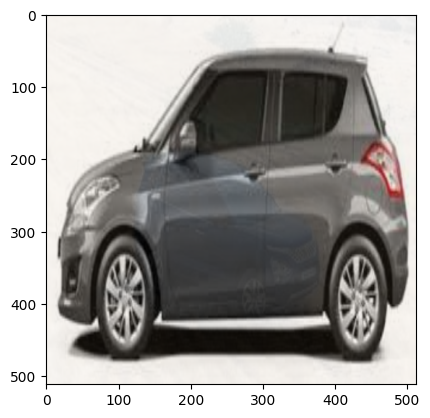

Epoch [1/5], Step [1/105], Loss: 33.2454


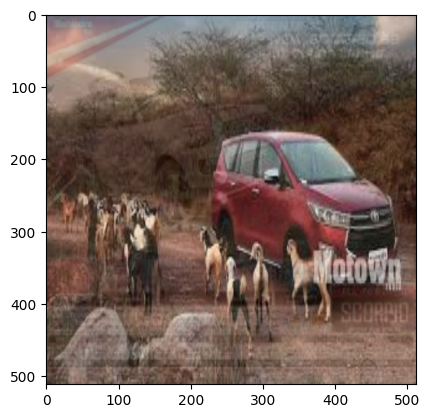

Epoch [1/5], Step [2/105], Loss: 18.7163


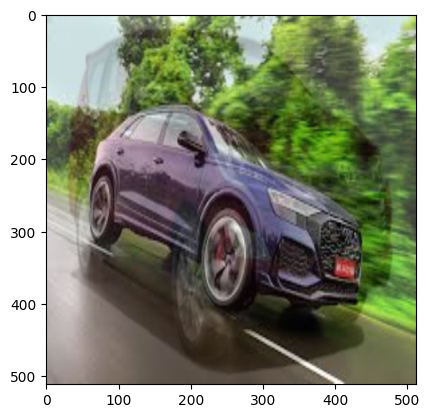

Epoch [1/5], Step [3/105], Loss: 12.1930


KeyboardInterrupt: 

In [100]:
for epoch in range(5):
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Применяем Mixup к данным
        mixed_images, mixed_labels = mixup_data(images, labels)

        plt.imshow(mixed_images[0].permute(1,2,0))
        plt.show()

        optimizer.zero_grad()

        # Прямой проход
        outputs = model(mixed_images)

        # Выбор одного класса для смешанных меток
        mixed_labels = torch.argmax(mixed_labels, dim=1)

        # Вычисление потерь с использованием смешанных меток
        loss = criterion(outputs, mixed_labels)

        loss.backward()
        optimizer.step()

        if (i+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{5}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

***Cutout: Случайное удаление квадратных областей из изображения, чтобы модель научилась игнорировать часть информации.***

In [102]:
class Cutout:
    def __init__(self, size):
        self.size = size  # Размер квадрата, который будет удален

    def __call__(self, img):
        # Получаем размеры изображения
        h, w = img.size(1), img.size(2)

        # Генерируем случайные координаты для верхнего левого угла квадрата
        x = np.random.randint(0, w)
        y = np.random.randint(0, h)

        # Вычисляем границы квадрата
        x1 = np.clip(x - self.size // 2, 0, w)
        y1 = np.clip(y - self.size // 2, 0, h)
        x2 = np.clip(x + self.size // 2, 0, w)
        y2 = np.clip(y + self.size // 2, 0, h)

        # Создаем маску и применяем ее к изображению
        mask = img.clone()
        mask[:, y1:y2, x1:x2] = 0

        return mask

In [116]:
# Определяем трансформ
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    Cutout(size=128),  # Удаляем квадрат размером 16x16 пикселей
])

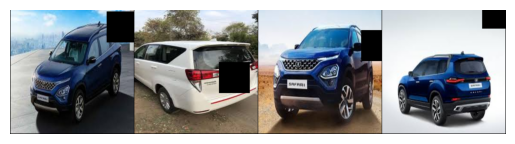

In [117]:
dataset_cutout = CustomData(path_csv,transform)
train_loader = DataLoader(dataset_cutout, batch_size=32, shuffle=True)

# Визуализация примеров с применением Cutout
def show_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    grid_img = torchvision.utils.make_grid(images[:4], nrow=4)
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

show_images(train_loader)

In [5]:
zip_file_name = '/content/drive/MyDrive/Colab Notebooks/github work_resume/Cars Dataset.zip'
# Распаковка ZIP-файла в текущую директорию

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
  zip_ref.extractall('cars')